In [404]:
import chipwhisperer as cw
scope = cw.scope()
scope.default_setup()
if scope._is_husky:
    scope.adc.samples = 80
else:
    scope.adc.samples = 129
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "disabled"

#TARGET_PLATFORM = 'CW305_100t'
TARGET_PLATFORM = 'CW305_35t'
# TARGET_PLATFORM = 'CW312T_A35'
#TARGET_PLATFORM = 'CW312T_ICE40'

if TARGET_PLATFORM in ['CW312T_A35', 'CW312T_ICE40']:
    scope.io.hs2 = 'clkgen'
    fpga_id = None # not needed
    if TARGET_PLATFORM == 'CW312T_A35':
        platform = 'ss2_a35'
        scope.gain.db = 45 # this is a good setting for the inductive shunt; if using another, adjust as needed
    else:
        platform = 'ss2_ice40'
        scope.gain.db = 15
else:
    scope.gain.db = 25
    scope.io.hs2 = "disabled"
    platform = 'cw305'
    if TARGET_PLATFORM == 'CW305_100t':
        fpga_id = '100t'
    elif TARGET_PLATFORM == 'CW305_35t':
        fpga_id = '35t'

# On the CW305, setting force=False only programs the FPGA if it is currently unprogrammed, whereas force=True programs the FPGA regardless.
# This option isn't available on the CW312T_A35 or CW312T_ICE40.
# target = cw.target(scope, cw.targets.CW305, force=True, fpga_id=fpga_id, platform=platform)
# target = cw.target(None, cw.targets.CW305, force=True, bsfile="/home/boochoo/hqc/dummy-insertion-sparse-polymult/CW305/poly_mult/vivado_polymult_vulnerable_cw305/vivado_polymult_vulnerable_cw305.runs/impl_1/cw305_top.bit")


scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 629903                    to 21352743                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 0                         to 29538459                 
scope.clock.adc_rate                     changed from 0.0                       to 29538459.0               
scope.clock.freq_ct

In [852]:
target = cw.target(None, cw.targets.CW305, force=True, bsfile="/home/boochoo/hqc/dummy-insertion-sparse-polymult/CW305/poly_mult/vivado_polymult_vulnerable_cw305/vivado_polymult_vulnerable_cw305.runs/impl_1/cw305_top.bit")

(ChipWhisperer Target WARNING|File CW305.py:591) Using default Verilog defines (/home/boochoo/chipwhisperer/software/chipwhisperer/hardware/firmware/cw305/cw305_aes_defines.v); if this is not what you want, provide them via the defines_files argument


In [853]:
scope.adc.samples = 300

In [854]:
if TARGET_PLATFORM in ['CW305_100t', 'CW305_35t']:
    target.vccint_set(1.0)
    # we only need PLL1:
    target.pll.pll_enable_set(True)
    target.pll.pll_outenable_set(False, 0)
    target.pll.pll_outenable_set(True, 1)
    target.pll.pll_outenable_set(False, 2)

    # run at 10 MHz:
    target.pll.pll_outfreq_set(10E6, 1)

    # 1ms is plenty of idling time
    target.clkusbautooff = True
    target.clksleeptime = 1

if TARGET_PLATFORM in ['CW305_100t', 'CW305_35t']:
    if scope._is_husky:
        scope.clock.clkgen_freq = 10e6
        scope.clock.clkgen_src = 'extclk'
        scope.clock.adc_mul = 4
        # if the target PLL frequency is changed, the above must also be changed accordingly
    else:
        scope.clock.adc_src = "extclk_x4"
        
if TARGET_PLATFORM in ['CW312T_A35', 'CW312T_ICE40']:
    scope.clock.clkgen_freq = 7.37e6
    scope.io.hs2 = 'clkgen'
    if scope._is_husky:
        scope.clock.clkgen_src = 'system'
        scope.clock.adc_mul = 4
        scope.clock.reset_dcms()
    else:
        scope.clock.adc_src = "clkgen_x4"
    import time
    time.sleep(0.1)
    target._ss2_test_echo()

import time
for i in range(5):
    scope.clock.reset_adc()
    time.sleep(1)
    if scope.clock.adc_locked:
        break 
assert (scope.clock.adc_locked), "ADC failed to lock"

project_file = "projects/polymult_vulnerable.cwp"
project = cw.create_project(project_file, overwrite=True)

In [855]:
def read_y_128_mem_as_int_list(filename):
    """ 
    y_128.mem 파일을 읽고 각 줄을 2진수에서 정수로 변환하여 리스트로 반환 
    """
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # 2진수를 정수(int)로 변환하여 리스트에 저장
    int_list = [int(line.strip(), 2) for line in lines]
    
    return int_list

def number_to_bytearray(num, high_bits=0, size=16):
    """ 
    숫자를 지정된 바이트 크기로 변환하는 함수.
    high_bits (0~3): 최상위 2비트 (128, 127 비트)를 설정할 값
    """
    if not (0 <= high_bits <= 3):
        raise ValueError("high_bits는 0~3 사이의 값이어야 합니다.")

    # 126비트 값만 유지하고, 최상위 2비트는 high_bits로 변경
    num = (num & ((1 << 126) - 1)) | (high_bits << 126)

    return num.to_bytes(size, byteorder='little')

def read_key(index):
    target.fpga_write(target.REG_CRYPT_TEXTIN, bytearray(16))
    target.fpga_write(target.REG_CRYPT_KEY, number_to_bytearray(index, 0))
    target.go()
    result_byte = target.fpga_read(target.REG_CRYPT_CIPHEROUT, 16)
    return int.from_bytes(result_byte, byteorder='little')

In [965]:

# key_value = read_y_128_mem_as_int_list("/home/boochoo/hqc/dummy-insertion-sparse-polymult/CW305/poly_mult/jupyter/y_128.mem")
# key_value = read_y_128_mem_as_int_list("/home/boochoo/hqc/dummy-insertion-sparse-polymult/CW305/poly_mult/jupyter/secret_66_1.mem")
key_value = read_y_128_mem_as_int_list("/home/boochoo/hqc/dummy-insertion-sparse-polymult/CW305/poly_mult/jupyter/secret_66_2.mem")
# plain_values = read_y_128_mem_as_int_list("/home/boochoo/hqc/dummy-insertion-sparse-polymult/CW305/poly_mult/jupyter/h_for_y_32.mem")
plain_values = read_y_128_mem_as_int_list("/home/boochoo/hqc/dummy-insertion-sparse-polymult/CW305/poly_mult/jupyter/plaintext_1.mem")
# plain_values = read_y_128_mem_as_int_list("/home/boochoo/hqc/dummy-insertion-sparse-polymult/CW305/poly_mult/jupyter/plaintext_2.mem")


In [966]:
for i in range(len(key_value) + len(plain_values)):
    target.fpga_write(target.REG_CRYPT_KEY, number_to_bytearray(i,0))
    if i < len(key_value):
        target.fpga_write(target.REG_CRYPT_TEXTIN, key_value[i].to_bytes(16, byteorder='little'))
    else:
        target.fpga_write(target.REG_CRYPT_TEXTIN, plain_values[i-len(key_value)].to_bytes(16, byteorder='little'))
    target.go()


In [967]:
print(key_value[0])
print(key_value[1])
print(len(key_value))
print(plain_values[0])
print(plain_values[1])
print(len(plain_values))
print(read_key(0))
print(read_key(1))

883
1708
2
2027333973
2711841299
553
883
1708


In [968]:
if read_key(0) == key_value[0]:
    print("Key value is correct")

if read_key(len(plain_values) + len(key_value) - 1) == plain_values[len(plain_values) - 1]:
    print("Plain value is correct")

Key value is correct
Plain value is correct


In [969]:
target.fpga_write(target.REG_CRYPT_TEXTIN, bytearray([0xFF] * 16))
target.fpga_write(target.REG_CRYPT_KEY, number_to_bytearray(7000, 0))
target.go()


In [970]:

answer = target.fpga_read(target.REG_CRYPT_CIPHEROUT, 16)
print(int.from_bytes(answer, byteorder='little'))

3662557605


In [971]:
from tqdm.notebook import tnrange

traces = []
N = 300  # Number of traces
for i in tnrange(N, desc='Capturing traces'):

    ret = cw.capture_trace(scope, target, bytearray([0xFF] * 16), number_to_bytearray(7000, 0))
    if not ret:
        print("Failed capture")
        continue
    
    response = target.fpga_read(target.REG_CRYPT_CIPHEROUT, 16)
    if response != answer:
        print("Failed response")
        continue
    traces.append(ret.wave)
    project.traces.append(ret)

Capturing traces:   0%|          | 0/300 [00:00<?, ?it/s]

In [972]:
# print(traces[0])
print(len(traces[0]))
print(len(traces))

300
300


In [973]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()
p = figure(width=1000)

xrange = list(range(len(traces[0])))
p.line(xrange, traces[0], line_color="red")
show(p)

Loading BokehJS ...

In [974]:
import csv

def save_to_csv(data, filename):
    """
    2차원 리스트를 CSV 파일로 저장하는 함수

    :param data: 2차원 리스트 (리스트의 리스트)
    :param filename: 저장할 CSV 파일명 (예: "output.csv")
    """
    try:
        with open(filename, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerows(data)
        print(f"CSV 파일이 성공적으로 저장되었습니다: {filename}")
    except Exception as e:
        print(f"파일 저장 중 오류 발생: {e}")


save_to_csv(traces, "/home/boochoo/hqc/dummy-insertion-sparse-polymult/CW305/poly_mult/jupyter/traces.csv")

CSV 파일이 성공적으로 저장되었습니다: /home/boochoo/hqc/dummy-insertion-sparse-polymult/CW305/poly_mult/jupyter/traces.csv


In [975]:
import numpy as np
traces = np.array(traces)

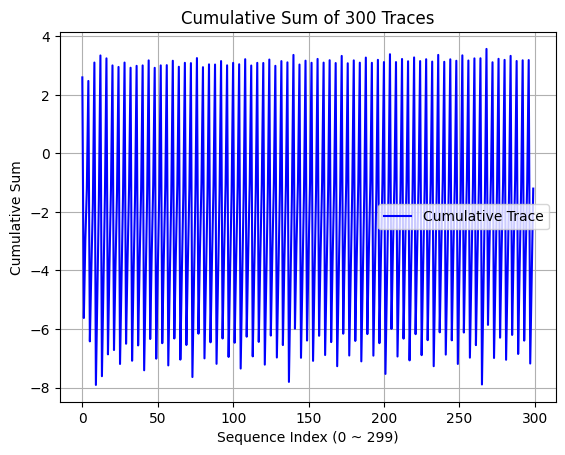

In [976]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_trace(data, N=5000, length=300):
    """
    5000개의 200길이 데이터를 x축 기준으로 모두 누적하여 시각화하는 함수

    :param data: (5000, 200) 형태의 2차원 NumPy 배열
    """
    # 데이터가 올바른 형태인지 확인
    if len(data.shape) != 2 or data.shape[1] != length:
        raise ValueError("Input data must have a shape of (N, length)")

    # x축 기준으로 누적 합 계산 (axis=0)
    cumulative_trace = np.sum(data, axis=0)

    # 그래프 그리기
    plt.plot(range(length), cumulative_trace, label="Cumulative Trace", color='b')
    plt.xlabel(f"Sequence Index (0 ~ {length-1})")
    plt.ylabel("Cumulative Sum")
    plt.title(f"Cumulative Sum of {N} Traces")
    plt.legend()
    plt.grid()
    plt.show()
    
    return cumulative_trace/5000

cumulative_trace = plot_cumulative_trace(traces, N=N,length = scope.adc.samples)

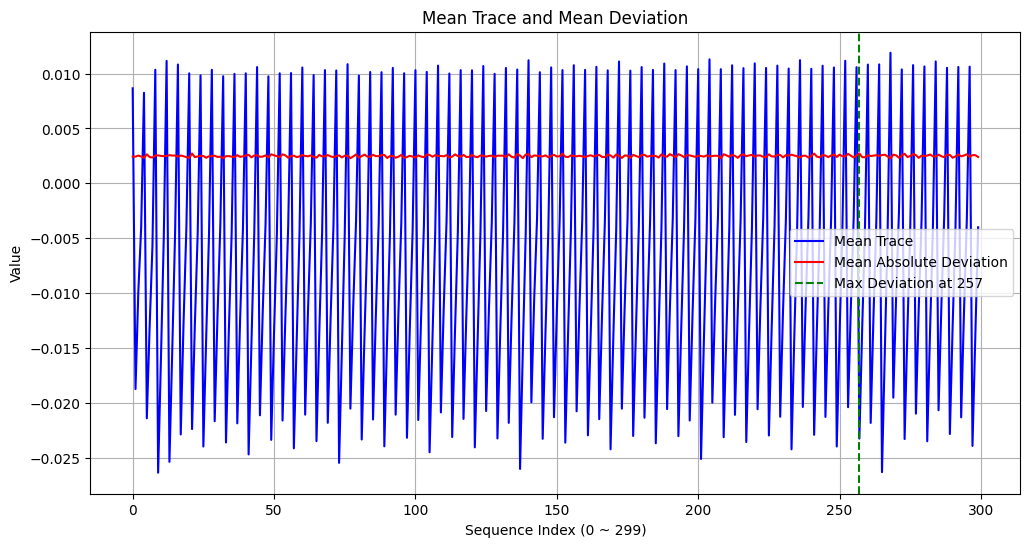

Maximum deviation occurs at index 257 with a value of 0.0027


In [977]:
def analyze_trace_variation(data, N=5000, length=300):
    """
    5000개의 트레이스 평균 및 각 트레이스와 평균의 차이를 분석하는 함수

    :param data: (5000, 300) 형태의 2차원 NumPy 배열
    """
    # 데이터가 올바른 형태인지 확인
    if len(data.shape) != 2 or data.shape[1] != length:
        raise ValueError("Input data must have a shape of (N, length)")

    # 평균 트레이스 계산
    mean_trace = np.mean(data, axis=0)

    # 각 트레이스와 평균의 차이 계산 (절대값 기준)
    deviation = np.abs(data - mean_trace)  # (5000, 300) 크기의 편차 행렬
    mean_deviation = np.mean(deviation, axis=0)  # 각 포인트별 평균 차이 계산

    # 차이가 가장 큰 지점 찾기
    max_deviation_index = np.argmax(mean_deviation)
    max_deviation_value = mean_deviation[max_deviation_index]

    # 그래프 그리기
    plt.figure(figsize=(12, 6))

    # 평균 트레이스 그래프
    plt.plot(range(length), mean_trace, label="Mean Trace", color='b')

    # 평균 차이 그래프
    plt.plot(range(length), mean_deviation, label="Mean Absolute Deviation", color='r')

    # 차이가 가장 큰 지점 표시
    plt.axvline(x=max_deviation_index, color='g', linestyle='--', label=f"Max Deviation at {max_deviation_index}")

    plt.xlabel(f"Sequence Index (0 ~ {length-1})")
    plt.ylabel("Value")
    plt.title("Mean Trace and Mean Deviation")
    plt.legend(loc="center right")
    plt.grid()
    plt.show()

    print(f"Maximum deviation occurs at index {max_deviation_index} with a value of {max_deviation_value:.4f}")

    return mean_trace, mean_deviation, max_deviation_index, max_deviation_value



# 분석 실행
mean_trace, mean_deviation, max_deviation_index, max_deviation_value = analyze_trace_variation(traces, length=scope.adc.samples)